# Samenhang

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.cm as cm

## Correlatie

In [2]:
linkedin = pd.read_csv("linkedIn.csv", sep=",", decimal=".", header=0)
linkedin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2064 entries, 0 to 2063
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   loon        2064 non-null   int64
 1   connecties  2064 non-null   int64
dtypes: int64(2)
memory usage: 32.4 KB


In [3]:
linkedin.head()

,loon,connecties
0,3252,304
1,2968,216
2,2976,159
3,3255,273
4,1953,191


Text(0, 0.5, 'bruto loon (EUR)')

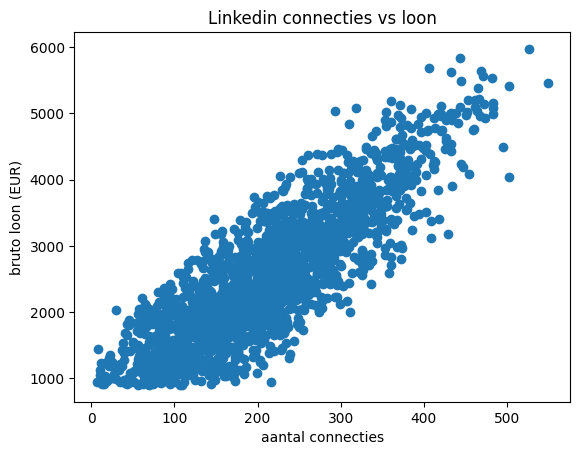

In [4]:
fig, ax = plt.subplots()
ax.scatter(linkedin.connecties, linkedin.loon)
ax.set_title('Linkedin connecties vs loon')
ax.set_xlabel('aantal connecties')
ax.set_ylabel('bruto loon (EUR)')
#fig.show()

In [5]:
# Pearson
linkedin_scaled = pd.DataFrame(stats.zscore(linkedin)) # wat is dit?
linkedin_scaled.head()

,loon,connecties
0,0.736521,0.991610
1,0.448105,0.059547
2,0.456230,-0.544176
3,0.739568,0.663270
4,-0.582676,-0.205244


In [6]:
c = (linkedin_scaled.loon*linkedin_scaled.connecties).mean()
print(c)

0.854603892685227


In [ ]:
c = linkedin.connecties.corr(linkedin.loon)
print(c)

In [ ]:
# rangcorrelatie
connecties_cutpoints = [0,30,150,250,300,400,600]
connecties_categories = ["weinig","matig","gemiddeld","meer","veel","extreem veel"]
loon_cutpoints = [0,2000,3000,5000,6000]
loon_categories = ["klein","modaal","groot","extreem"]
connecties = pd.cut(linkedin.connecties, bins=connecties_cutpoints)
connecties = connecties.cat.rename_categories(connecties_categories)
loon = pd.cut(linkedin.loon, bins=loon_cutpoints)
loon = loon.cat.rename_categories(loon_categories)
print(pd.DataFrame({'connecties':connecties, 'loon':loon}))

In [ ]:
waarden = pd.Series([10, 5, 12, 1])
print(waarden.rank())

In [ ]:
# Spearman
loon_rang = loon.rank()
connecties_rang = connecties.rank()
connecties_rang.corr(loon_rang)

In [ ]:
# vereenvoudigde versie, niet gebruiken!
def kendall_simple(x,y):
  x = x.rank()
  y = y.rank()
  n = len(x)
  score = 0
  for i in range(1,n-1):
    for j in range(i+1,n):
      score = score + np.sign(x[i]-x[j]) * np.sign(y[i]-y[j])
  return 2*score/n/(n-1)

In [ ]:
connecties_rang.corr(loon_rang, method="kendall")

In [ ]:
# let op:
connecties.corr(loon, method="kendall")

## Regressie

In [ ]:
x = linkedin.connecties
y = linkedin.loon

In [ ]:
# op zoek naar a en b...
n = 16
se = np.zeros([n, n])
A = np.linspace(500, 800, n)
B = np.linspace(7, 10, n)
for i in range(n):
    a = A[i]
    for j in range(n):
        b = B[j]
        predicted = a + b * x
        error = y - predicted
        se[i][j] = math.sqrt((error ** 2).mean())

In [ ]:
xx, yy = np.meshgrid(A, B)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, se, cmap=cm.coolwarm, antialiased=False, edgecolor='black')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('se')
plt.show()

In [ ]:
# a en b met formules
b = x.corr(y) * y.std() / x.std()
a = y.mean() - b * x.mean()
print(a)
print(b)

In [ ]:
# a en b met functie berekenen
model = np.polyfit(x, y, 1)
print(model)
a = model[1]
b = model[0]
print(a)
print(b)

In [ ]:
# loon van iemand met 200 connecties:
print(a + b * 200)
predict = np.poly1d(model)
predict(200)

In [ ]:
# wat is het loon van Kris Demuynck? :-)

In [ ]:
# de standaardschattingsfout (ook RMSE genoemd)
se = math.sqrt(((predict(x)-y)**2).mean())
print(se)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x, y)
xx = np.linspace(x.min(), x.max(), 100)
yy = predict(xx)
ax.fill_between(xx, yy-se, yy+se, color="#FFFF0080")
ax.plot(xx, yy, color="red")
ax.set_title('Linkedin connecties vs loon')
ax.set_xlabel("aantal connecties")
ax.set_ylabel("bruto loon (EUR)")
#fig.show()

In [ ]:
# verklaarde variantie
r_squared = (x.corr(y))**2
print(r_squared)

In [ ]:
def general_regression(x:pd.Series, y:pd.Series, degree=1, exp=False, log=False):
    fun_y = inv_fun_y = lambda x:x
    fun_x = lambda x:x
    if (exp):
        fun_y = np.exp
        inv_fun_y = np.log
    if (log):
        fun_x = np.log
    model = np.polyfit(fun_x(x), inv_fun_y(y), degree)
    line = np.poly1d(model)
    predict = lambda x:fun_y(line(fun_x(x)))
    predicted = predict(x)
    squared_residuals = (predicted-y)**2
    variance_y = (y-y.mean())**2
    se = math.sqrt(squared_residuals.mean())
    r2 = 1 - (squared_residuals.sum() / variance_y.sum())
    result = [se, r2, predict] + [model[-i] for i in range(1, len(model)+1)]
    index = ["se", "r2", "predict"] + [chr(i+96) for i in range(1, len(model)+1)]
    return pd.Series(result, index=index)

In [ ]:
result = general_regression(x, y, 3)
print(result)

In [ ]:
result.predict(200)

In [ ]:
result = general_regression(x, y, exp=True)
print(result)

In [ ]:
result.predict(200)

In [ ]:
result = general_regression(x, y, log=True)
print(result)

In [ ]:
def plot_regressionline(ax, reg_result, min, max, linecol="red", plot_error=False, errorcol="#FFFF0080"):
    se = reg_result.se
    x = np.arange(min, max, (max-min)/100)
    y = reg_result.predict(x)
    if plot_error:
        ax.fill_between(x, y-se, y+se, color=errorcol)
    ax.plot(x, y, color=linecol)

In [ ]:
result1 = general_regression(x, y, 2)
result2 = general_regression(x, y, 3)
result3 = general_regression(x, y, exp=True)
result4 = general_regression(x, y, log=True)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
plt.subplots_adjust(hspace=0.7, wspace=0.6)
ax1.scatter(x,y)
ax2.scatter(x,y)
ax3.scatter(x,y)
ax4.scatter(x,y)
plot_regressionline(ax1, result1, x.min(), x.max(), plot_error=True)
plot_regressionline(ax2, result2, x.min(), x.max(), plot_error=True)
plot_regressionline(ax3, result3, x.min(), x.max(), plot_error=True)
plot_regressionline(ax4, result4, x.min(), x.max(), plot_error=True)
ax1.set_xlabel("aantal connecties")
ax2.set_xlabel("aantal connecties")
ax3.set_xlabel("aantal connecties")
ax4.set_xlabel("aantal connecties")
ax1.set_ylabel("bruto loon (EUR)")
ax2.set_ylabel("bruto loon (EUR)")
ax3.set_ylabel("bruto loon (EUR)")
ax4.set_ylabel("bruto loon (EUR)")
ax1.set_title("Kwadratische regressie")
ax2.set_title("Kubische regressie")
ax3.set_title("Exponentiële regressie")
ax4.set_title("Logaritmische regressie")
#fig.show()